# Demo

### Contents

    1. Set environment
    2. Set hyper-parameter
    3. Create dataloader
    4. Initialize the model
    5. Set optimizer
    6. Train
    7. Evaluate
    8. Load the model
    9. Application (paraphrase generation)


### 1. Set environment

In [1]:
!pip list

Package                Version
---------------------- --------------
absl-py                1.3.0
aiohttp                3.8.3
aiosignal              1.2.0
argon2-cffi            21.3.0
argon2-cffi-bindings   21.2.0
async-generator        1.10
async-timeout          4.0.2
asynctest              0.13.0
attrs                  22.1.0
backcall               0.2.0
bleach                 1.5.0
blis                   0.7.9
catalogue              2.0.8
certifi                2021.5.30
cffi                   1.15.1
charset-normalizer     2.0.12
click                  8.0.4
confection             0.0.3
contextvars            2.4
cymem                  2.0.7
dataclasses            0.8
datasets               2.4.0
decorator              5.1.1
defusedxml             0.7.1
dill                   0.3.4
easydict               1.10
en-core-web-sm         3.4.1
entrypoints            0.4
enum34                 1.1.10
filelock               3.4.1
frozenlist             1.2.0
fsspec                 2022.1

In [2]:
## own code
import sys

sys.path.append('/home/saemeechoi/smchoi/GP-VAE/models/pg')

In [3]:
## own code
import torch

GPU_NUM = 1
device = torch.device(f'cuda:{GPU_NUM}')
torch.cuda.set_device(device)

In [4]:
## own code
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [5]:
## own code
os.getcwd()

'/home/saemeechoi/smchoi/GP-VAE/models/pg/notebook'

### 2. Set hyper-parameter

In [6]:
## own code
from easydict import EasyDict as edict

args = edict({'task': 'train',
             'data_file': '../../../data/twitter_url_demo',
             'model_type': 'gp_full',
             'kernel_v': 65.0,
             'kernel_r': 0.0001,
             'epochs':1,
             'batch_size': 64,
             'optim': 2,
             'lr': 0.001,
             'grad_clip': 5.0,
             'val_step': 1,
             'print_step': 100,
              'kw': 0.,
              'x0': 25000,
              'embed_size': 300,
              'hidden_size': 512,
              'latent_size': 256,
              'word_dropout': 0,
              'embed_dropout': 0.5,
              'components': 10,
              'kld_sampled':0,
              'vocab_size': 20000,
              'max_len': 30,
              'using_cuda': True,
              'sample_num': 10,
              'beam_size': 10,
              'model_file': None,
              'topn':10,
              'std':1.,
              'decode_from': 'sample',
              'seed': 123
             })

### 3. Create DataLoader

In [7]:
## own code
import pandas as pd

# Show raw data
pd.read_csv(f'{args.data_file}/trn.tsv', sep='\t', header=None).head()

,0,1
0,ABC News staged crime-scene shot with police t...,More reason why the media can't always be trus...
1,The Pentagon says China will return a U.S. Nav...,China to return seized Navy drone AGAIN PE TRU...
2,Myanmar seeking ethnic cleansing of Muslim Roh...,The BBC app is worth downloading RIGHT NOW . M...
3,"Dylann Roof , the white supremacist who shot 9...",White supremacist terrorist Roof found guilty .
4,President-elect @realDonaldTrump knocks border...,"Trump blasts ' dishonest media , ' insists Mex..."


In [8]:
## refactoring the auther's code
import os
import spacy
from torchtext.data import Field, TabularDataset, BucketIterator

spacy_en = spacy.load('en_core_web_sm')

# Tokenize English sentence
def tokenize_fn(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# Define field
TXT = Field(tokenize=tokenize_fn, init_token='<sos>', eos_token='<eos>', lower=True)

# Source and target both are text
fields = [("src", TXT), ("trg", TXT)]

# Create a Dataset instance 
trn_data = TabularDataset(os.path.join(args.data_file,'trn'+".tsv"), format="TSV", fields=fields, skip_header=False)
val_data = TabularDataset(os.path.join(args.data_file,'val'+".tsv"), format="TSV", fields=fields, skip_header=False)
tst_data = TabularDataset(os.path.join(args.data_file,'tst'+".tsv"), format="TSV", fields=fields, skip_header=False)

# Build vocab using training data
TXT.build_vocab(trn_data, min_freq=1, vectors="glove.6B.100d") # max_size=15000

# Create iterator
train_iter, val_iter, test_iter = BucketIterator.splits((trn_data, val_data, tst_data), 
                                                        batch_size=args.batch_size, 
                                                        sort_key=lambda x: len(x.src),
                                                        sort=True,
                                                        shuffle=False,
                                                        repeat=False)
txtfield = TXT

print("[TRAIN]:%d (dataset:%d)\t[VAL]:%d (dataset:%d)\t[TEST]:%d (dataset:%d)"
      % (len(train_iter), len(train_iter.dataset),
         len(val_iter), len(val_iter.dataset),
         len(test_iter), len(test_iter.dataset)))
print("[vocab]:%d" % (len(txtfield.vocab)))

/home/saemeechoi/anaconda3/envs/gpvae/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


[TRAIN]:300 (dataset:19200)	[VAL]:16 (dataset:1000)	[TEST]:47 (dataset:3000)
[vocab]:19062


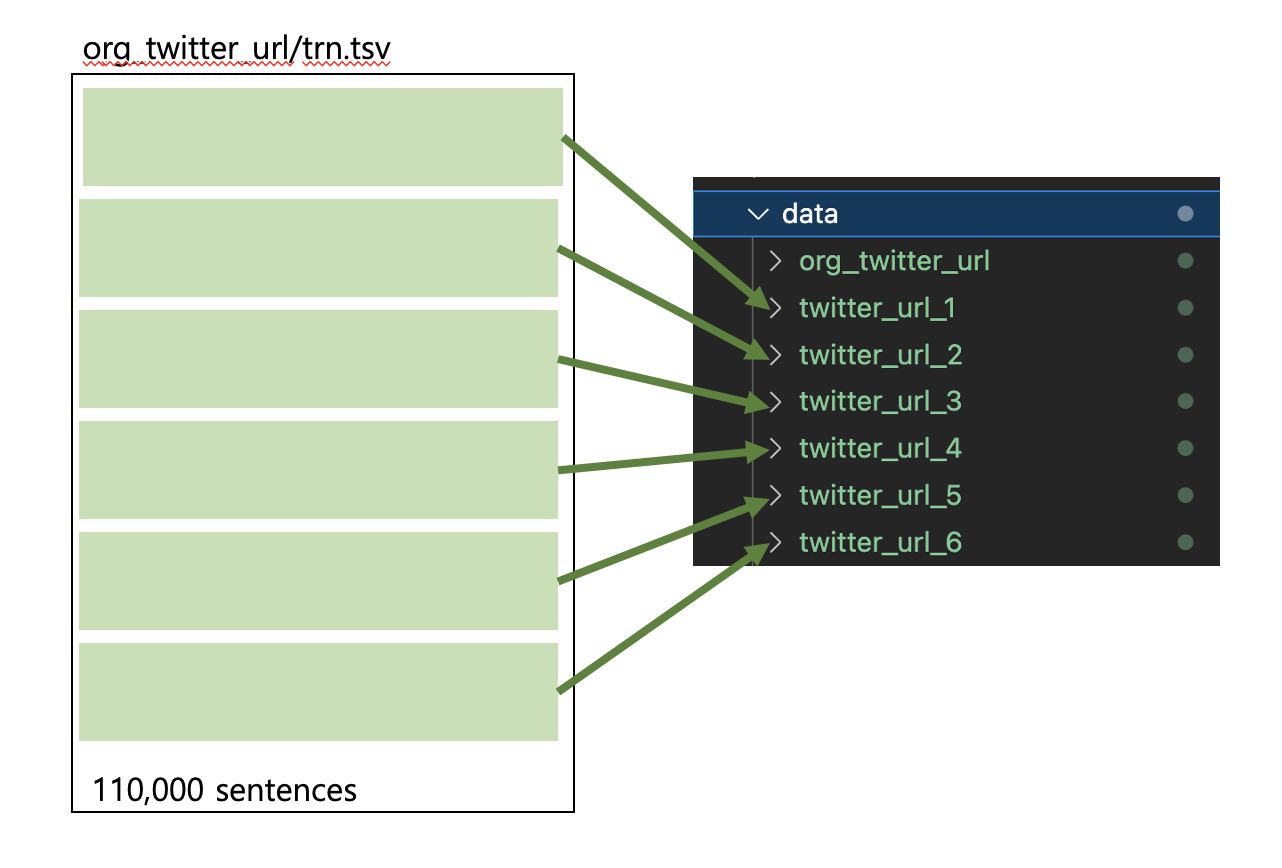

In [16]:
## own code
# Example of source text

' '.join(list(iter(trn_data.src))[0])

'abc news staged crime - scene shot with police tape , photograph shows'

In [17]:
## own code
# Example of target text

' '.join(list(iter(trn_data.trg))[0])

"more reason why the media ca n't always be trusted abc news staged crime - scene shot , photo shows"

### 4. Initialize the model

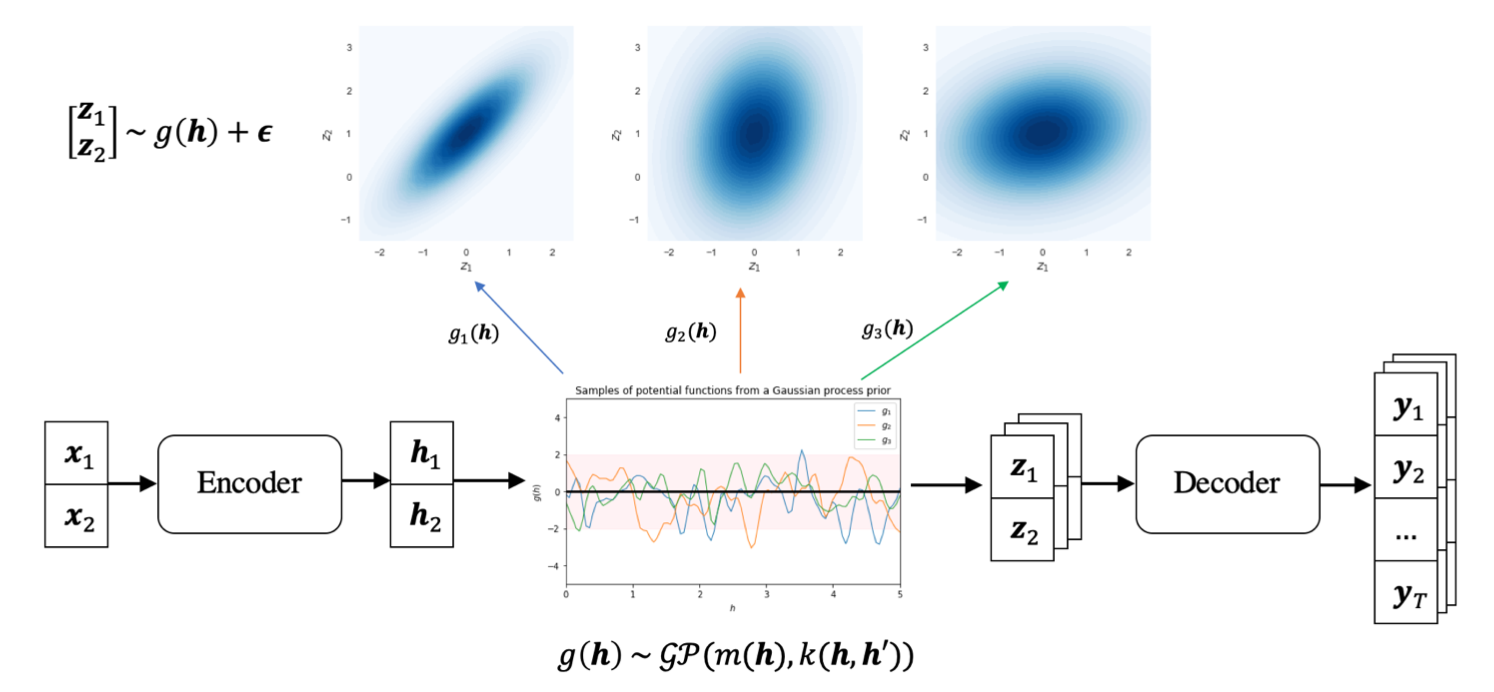 

- Encoder-decoder architecture type

    1. Pointer-generator (PG)
    
    2. text-to-text transfer transformer (T5)
    

In [11]:
## refactoring the author's code
from model import GP_Full


# Create model instance
model = GP_Full(args, txtfield)
model = model.cuda()

In [12]:
model

GP_Full(
  (embedding): Embedding(20000, 300)
  (bi_lstm): LSTM(300, 512, batch_first=True, bidirectional=True)
  (hidden2latent): Linear(in_features=1024, out_features=256, bias=True)
  (latent2hidden): Linear(in_features=256, out_features=1024, bias=True)
  (reduce_h): Linear(in_features=1024, out_features=512, bias=True)
  (reduce_c): Linear(in_features=1024, out_features=512, bias=True)
  (W_h): Linear(in_features=1024, out_features=1024, bias=False)
  (W_c): Linear(in_features=1, out_features=1024, bias=False)
  (decode_proj): Linear(in_features=1024, out_features=1024, bias=True)
  (v): Linear(in_features=1024, out_features=1, bias=False)
  (x_context): Linear(in_features=1324, out_features=300, bias=True)
  (uni_lstm): LSTM(300, 512, batch_first=True)
  (p_gen_linear): Linear(in_features=2348, out_features=1, bias=True)
  (out1): Linear(in_features=1536, out_features=512, bias=True)
  (out2): Linear(in_features=512, out_features=20000, bias=True)
  (mean): Linear(in_features=102

 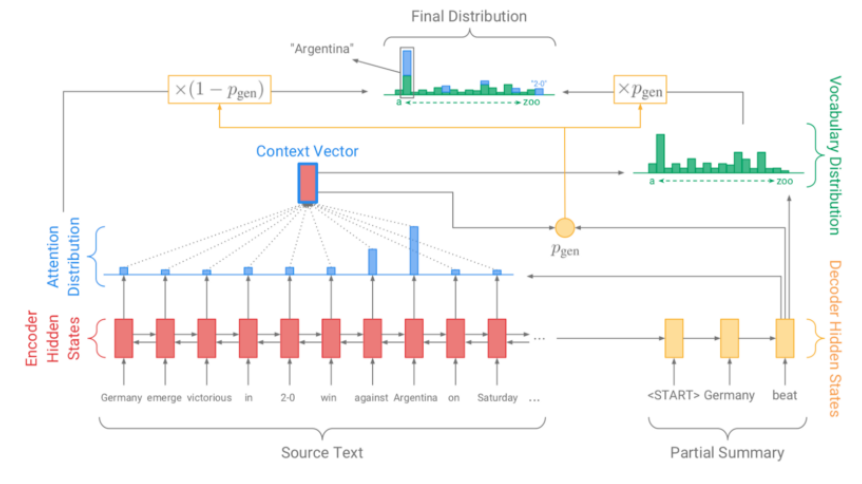

#### Bidirectional LSTM

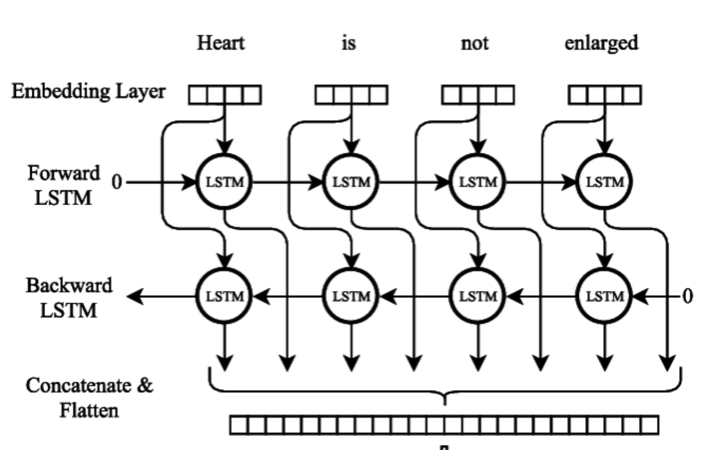

### 5. Set optimizer

In [13]:
## refactoring the author's code
from torch import optim


# Create optimizer instance
params = model.parameters()
optimizer = optim.Adam(params, lr=args.lr)

### 6. Train

In [14]:
## refactoring the author's code
import logging
import datetime
import tensorflow as tf
import absl.logging
from training import evaluate
logging.root.removeHandler(absl.logging._absl_handler)
absl.logging._warn_preinit_stderr = False

import torch
from torch import autograd
from torch.nn.utils import clip_grad_norm_ as clip_grad_norm
from utils import kl_anneal_weight

print("*** Training with validation ... ***")

# Check current time
curr_time = datetime.datetime.now()
time_stamp = "{}-{}-{}-{}-{}-{}".format(curr_time.year, curr_time.month, curr_time.day,
                                            curr_time.hour, curr_time.minute, curr_time.second)

# Set output directory name
data_file = args.data_file.split('/')[-1]
wpath = "logs_"+data_file
fprefix = '{}_k{}_h{}_c{}_r{}_v{}_t{}'.format(args.model_type, args.latent_size, 
                                              args.hidden_size, args.components, 
                                              args.kernel_r, args.kernel_v,
                                              time_stamp)
if not os.path.isdir(wpath):
    os.makedirs(wpath)
flog = os.path.join(wpath, fprefix+".log")
logging.basicConfig(format='%(asctime)s %(message)s',
                    datefmt='%Y-%m-%d %I:%M:%S %p',
                    handlers=[
                        logging.FileHandler(flog), # to file
                        logging.StreamHandler() # to stdout
                    ],
                    level=logging.INFO)
logging.info("File name prefix: {}".format(fprefix))
logging.info(args)
logging.info(model)

# -----------------------------
# Create tensorboard logs
eval_log = 'tensorboard_logs_'+data_file+'/' + fprefix
if not os.path.exists(eval_log):
    os.makedirs(eval_log)
summary_writer = tf.summary.FileWriter(eval_log)

# -----------------------------
# Start training
global_step = 0
early_stop = 0
best_val_loss = 1000
for e in range(1, args.epochs+1):
    for b, batch in enumerate(train_iter):
        
        # Set model to training mode
        model.train()
        
        # Initialize gradient to zeros
        optimizer.zero_grad()
        
        # Predict and calculate losses
        nll, kld = model(batch)
        kl_weight = kl_anneal_weight(global_step, args)

        loss = nll + kl_weight * kld
        
        # Backpropagate
        loss.backward()
        
        # Clip gradient
        clip_grad_norm(model.parameters(), args.grad_clip) 
        
        # Update weight
        optimizer.step()
        global_step += 1
        
        # Print result
        if global_step % args.print_step == 0:
            logging.info("[Epoch: %d] [Batch: %d/%d] [NLL: %.4f] [KLD: %.4f]" % 
                        (e, b+1, len(train_iter), nll, kld))
            
            # Add nll, kld into tensorboard
            train_nll = tf.Summary()
            train_nll.value.add(tag='train_nll', simple_value=nll)
            summary_writer.add_summary(train_nll, global_step=global_step)
            summary_writer.flush()
            train_kld = tf.Summary()
            train_kld.value.add(tag='train_kld', simple_value=kld)
            summary_writer.add_summary(train_kld, global_step=global_step)
            summary_writer.flush()
            kld_weight = tf.Summary()
            kld_weight.value.add(tag='kld_weight', simple_value=kl_weight)
            summary_writer.add_summary(kld_weight, global_step=global_step)
            summary_writer.flush()

    # Start validation
    if e % args.val_step == 0:

        val_nll, val_kld = evaluate(model, val_iter, txtfield, args)
        logging.info("Val => [Current NLL: %5.4f] [Current KLD: %5.4f] [Best Loss: %5.4f]" 
                     % (val_nll, val_kld, best_val_loss))

        val_loss = val_nll + val_kld
        early_stop += 1
        
        # Update the best model
        if val_loss < best_val_loss:
            print("[!] saving model...")
            torch.save(model.state_dict(), os.path.join(wpath, fprefix+".pt"))
            best_val_loss = val_loss
            early_stop = 0
            
        # Add val_loss into tensorboard
        loss_sum = tf.Summary()
        loss_sum.value.add(tag='val_loss', simple_value=val_loss)
        summary_writer.add_summary(loss_sum, global_step=int(e/args.val_step))
        summary_writer.flush()

    # Stop training if no improvement
    if early_stop > 10: 
        print('No improvement after 10 epochs, stop training ...')
        break


2022-12-01 06:04:17 PM File name prefix: gp_full_k256_h512_c10_r0.0001_v65.0_t2022-12-1-18-4-17
2022-12-01 06:04:17 PM {'task': 'train', 'data_file': '../../../data/twitter_url_demo', 'model_type': 'gp_full', 'kernel_v': 65.0, 'kernel_r': 0.0001, 'epochs': 1, 'batch_size': 64, 'optim': 2, 'lr': 0.001, 'grad_clip': 5.0, 'val_step': 1, 'print_step': 100, 'kw': 0.0, 'x0': 25000, 'embed_size': 300, 'hidden_size': 512, 'latent_size': 256, 'word_dropout': 0, 'embed_dropout': 0.5, 'components': 10, 'kld_sampled': 0, 'vocab_size': 20000, 'max_len': 30, 'using_cuda': True, 'sample_num': 10, 'beam_size': 10, 'model_file': None, 'topn': 10, 'std': 1.0, 'decode_from': 'sample', 'seed': 123}
2022-12-01 06:04:17 PM GP_Full(
  (embedding): Embedding(20000, 300)
  (bi_lstm): LSTM(300, 512, batch_first=True, bidirectional=True)
  (hidden2latent): Linear(in_features=1024, out_features=256, bias=True)
  (latent2hidden): Linear(in_features=256, out_features=1024, bias=True)
  (reduce_h): Linear(in_feature

*** Training with validation ... ***


2022-12-01 06:04:40 PM [Epoch: 1] [Batch: 100/300] [NLL: 6.2406] [KLD: 0.0036]
2022-12-01 06:05:07 PM [Epoch: 1] [Batch: 200/300] [NLL: 6.0401] [KLD: 0.0195]
2022-12-01 06:05:45 PM [Epoch: 1] [Batch: 300/300] [NLL: 5.9791] [KLD: 0.0000]
2022-12-01 06:05:46 PM Val => [Current NLL: 5.8346] [Current KLD: 0.9081] [Best Loss: 1000.0000]


[!] saving model...


### 7. Evaluation

In [15]:
## refactoring the author's code
from math import exp

print("*** Testing ... ***")

# Set model to evaluation mode
model.eval()
total_nll, total_kld, total_batch = 0., 0., 0.
for b, batch in enumerate(test_iter):
    with torch.no_grad():
        
        # Predict and calculate losses
        nll, kld = model(batch, test=True)
        total_nll += nll.item()
        total_kld += kld.item()
        total_batch += 1

avg_nll = total_nll / total_batch
avg_kld = total_kld / total_batch

test_nll = avg_nll
test_kld = avg_kld

print("[TEST] NLL: %5.4f KLD: %5.4f PPLx: %5.4f" % (test_nll, test_kld, exp(test_nll+test_kld)))

*** Testing ... ***
[TEST] NLL: 5.9066 KLD: 0.9544 PPLx: 954.3261


### 8. Load the model

In [18]:
## refactoring the author's code
args.model_file = 'logs_twitter_url_tot/best_model.pt'

print("Loading the pretrained model from: {}".format(args.model_file))

# Load the best model weights
model.load_state_dict(torch.load(args.model_file))

Loading the pretrained model from: logs_twitter_url_tot/best_model.pt


<All keys matched successfully>

In [19]:
## refactoring the author's code
from math import exp

print("*** Testing ... ***")

# Set model to evaluation mode
model.eval()
total_nll, total_kld, total_batch = 0., 0., 0.
for b, batch in enumerate(test_iter):
    with torch.no_grad():
        
        # Predict and calculate losses
        nll, kld = model(batch, test=True)
        total_nll += nll.item()
        total_kld += kld.item()
        total_batch += 1

avg_nll = total_nll / total_batch
avg_kld = total_kld / total_batch

test_nll = avg_nll
test_kld = avg_kld

print("[TEST] NLL: %5.4f KLD: %5.4f PPLx: %5.4f" % (test_nll, test_kld, exp(test_nll+test_kld)))

*** Testing ... ***
[TEST] NLL: 5.1754 KLD: 0.0405 PPLx: 184.1681


### 9. Application 

Paraphrase Generation

In [20]:
## refactoring the author's code
import random 
from decode import BeamSearch

# Set random seed
random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

# Decode sample using beam search
beam_searcher = BeamSearch(model, txtfield, args)
beam_searcher.decode_sample(test_iter, txtfield, args, num_samples=1)

growing divide between red and blue america
growing divide between red and blue america
the growing divide between red and blue america
growing divide between red and blue america
growing divide between red and blue america
the growing divide between red and blue america
growing divide between red and blue america
growing divide between red its first an blue america
growing divide between red its first an blue america
growing divide between red , blue america
the growing divide between red and blue america
the growing divide between red and blue america
growing divide between red and blue america .
growing divide between red and blue america
Input words: the growing divide between red and blue america
Ref words: education , wealth , new economy , and diversity divide u.s. divide between red and blue america ?
Pred words: growing divide between red and blue america
Percent of unique sentences: 0.35714285714285715

could your own immune system kill cancer ?
could your own immune system k

/home/saemeechoi/anaconda3/envs/gpvae/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/saemeechoi/anaconda3/envs/gpvae/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


donald trump finds an improbable ally in wikileaks
donald trump finds an improbable ally ally in
the finds an improbable ally in wikileaks
donald trump finds an improbable ally in
donald playing improbable ally in wikileaks
donald trump finds , improbable ally in wikileaks
trump finds an improbable ally in wikileaks
donald in wikileaks
in wikileaks
improbable ally in wikileaks
Input words: donald trump finds an improbable ally in wikileaks
Ref words: donald trump finds improbable ally in wikileaks u.s.
Pred words: donald trump finds an improbable ally in wikileaks
Percent of unique sentences: 1.0

how the brown rat conquered new york city
how the brown rat conquered new york city
how the brown rat conquered new york city .
how brown rat conquered new york city
how the # brown rat conquered new york city
was the brown rat conquered new york city
brown rat conquered new york city
how the brown conquered new york city
the brown rat conquered new york city
brown conquered new york city
Inp

/home/saemeechoi/anaconda3/envs/gpvae/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


watch our new series bitcoin and the blockchain
watch our new series bitcoin and the blockchain
watch our new series bitcoin and the blockchain
watch our new series bitcoin and the blockchain
watch our new series bitcoin and the blockchain .
watch our new series bitcoin its first an the blockchain
watch our new series bitcoin its first an blockchain
watch our new series bitcoin , the blockchain
watch our new series bitcoin and blockchain
watch our new series bitcoin , blockchain
Input words: watch our new series bitcoin and the blockchain
Ref words: retweeted <unk> <unk> watch our new series bitcoin and the .
Pred words: watch our new series bitcoin and the blockchain
Percent of unique sentences: 0.7

trump takes aim at first lady michelle obama
trump takes aim at first lady michelle obama
trump takes aim at first lady michelle obama .
trump takes aim at the lady michelle obama
the takes aim at first lady michelle obama
takes aim at first lady michelle obama
trump takes aim at lady mic

how artificial intelligence is changing online retail forever
how artificial intelligence is changing online retail forever
artificial intelligence is changing online retail forever
how artificial intelligence is changing online retail forever .
how artificial intelligence is changing online retail forever
how artificial intelligence is changing online retail forever
artificial intelligence is changing online retail forever
how artificial intelligence artificial intelligence is changing online retail forever
how artificial intelligence online retail forever
how artificial intelligence artificial forever
changing online retail forever
artificial forever
Input words: how artificial intelligence is changing online retail forever
Ref words: report on how # ai is changing online retail
Pred words: how artificial intelligence is changing online retail forever
Percent of unique sentences: 0.6666666666666666

wisconsin projected by abc news for @realdonaldtrump .
wisconsin projected by abc new

you can now check on a facebook chatbot
you can now check on a facebook chatbot with times all
you can now check on a facebook chatbot via radio
you can now check on a facebook chatbot .
you can now check on a facebook chatbot via radio
you can now check on a facebook chatbot
the you can now check on a facebook chatbot
you can now check on a facebook chatbot
you can now check on a facebook chatbot via twitter
you can now check on a facebook chatbot via twitter
Input words: you can now check on a facebook chatbot
Ref words: you can now check via a facebook chatbot
Pred words: you can now check on a facebook chatbot
Percent of unique sentences: 0.6

gretchen carlson on her fight against sexual harassment
gretchen on her fight against sexual harassment
gretchen carlson a her fight against sexual harassment
gretchen carlson ' her fight against sexual harassment
her fight against sexual harassment
gretchen carlson on her fight against sexual harassment
gretchen carlson " her fight against s

watch the disney <unk> demo day here
watch the disney <unk> demo day here .
watch the disney <unk> demo day here
disney <unk> demo day here
the disney <unk> demo day here
watch the <unk> demo day here
watch disney <unk> demo day here
<unk> demo day here
disney <unk> demo day here .
watch day here
demo day here
Input words: watch the disney <unk> demo day here
Ref words: watch the disney <unk> demo day , right here
Pred words: watch the disney <unk> demo day here
Percent of unique sentences: 0.9090909090909091

david letterman shop at target these days
david letterman shop at target these days
david letterman shop at target these days with times all
david letterman david letterman shop at target these days
david letterman shop at target these days
david letterman shop at target these days
david letterman david letterman shop at target these days
david letterman shop at target these days
david letterman to target these days
david letterman at target these days
david letterman 's target t

facebook finally starts showing ads in groups
facebook finally starts showing ads in groups
facebook finally starts showing ads in groups
facebook finally starts showing ads in groups
facebook finally to starts showing ads in groups
facebook finally starts showing ads stop groups
facebook finally starts showing ads in groups
facebook finally starts showing ads in groups
facebook finally starts showing ads in groups
facebook finally starts showing ads in groups
facebook finally starts showing ads in groups
facebook finally starts showing ads in groups
Input words: facebook finally starts showing ads in groups
Ref words: where facebook is going to start posting ads
Pred words: facebook finally starts showing ads in groups
Percent of unique sentences: 0.25

how does the electoral college work ?
how does the electoral college work ?
how does the electoral college work ?
how does the electoral college work ? .
how does the electoral college work ?
how does the electoral college work ?
how d

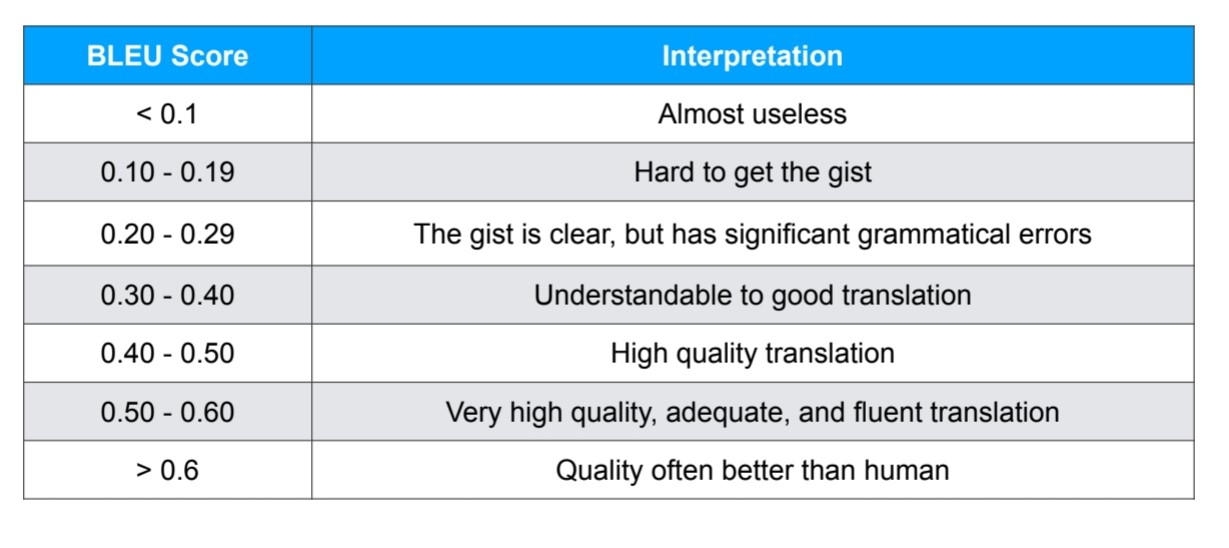

In [21]:
## own code
new_src_text = "I'm so tired that I'll sleep as soon as I go home"
new_ref_test = "I'm so tired and I'll sleep when I get home"
pd.DataFrame([[new_src_text, new_ref_test]]).to_csv(f'{args.data_file}/sample.tsv',sep='\t', header=None, index=None)

sample_data = TabularDataset(os.path.join(args.data_file,'sample'+".tsv"), format="TSV", fields=fields, skip_header=False)
sample_iter = BucketIterator(sample_data, 
                            batch_size=args.batch_size, 
                            sort_key=lambda x: len(x.src),
                            sort=True,
                            shuffle=False,
                            repeat=False)

In [22]:
## own code
beam_searcher.decode_sample(sample_iter, txtfield, args, num_samples=1)

i 'm so tired that i 'll sleep as soon as i go home
i 'm so tired that i 'll sleep as soon as i go home .
i 'm so tired that i 'll sleep as soon as i go home
i for tired that i 'll sleep as soon as i go home
i 'm so tired , i 'll sleep as soon as i go home
i 'm so tired that i 'll sleep as soon as i go home
i 'm so tired that i 'll sleep as soon as i go home via radio
i 'm so tired that i 'll sleep as soon as i go home
i 'm so tired that i 'll sleep as soon as i go
i 'm so tired that i 'll sleep as soon as i go home
i 'm so tired that i 'll sleep as soon
Input words: i 'm so tired that i 'll sleep as soon as i go home
Ref words: i 'm so tired and i 'll sleep when i get home
Pred words: i 'm so tired that i 'll sleep as soon as i go home
Percent of unique sentences: 0.6363636363636364

Average BLEU score: 0.2737928561916526
Average Unique sentences: 0.636
